# Machine Learning Model to Predict Pulsar Signals from Image Dataset

## Approach to the Image Model

For the image-based classification of pulsar signals, the following approach was implemented:

1. **Model Architecture:**
   - A **Convolutional Neural Network (CNN)** was developed to classify pulsar signals from **32x32 RGB images**.
   - The architecture consisted of:
     - Multiple **convolutional layers** with increasing filter depths for feature extraction.
     - **Max-pooling layers** for downsampling and reducing the spatial dimensions.
     - **Fully connected layers** for final classification.

2. **Handling Data Imbalance:**
   - To address the issue of data imbalance, **Weighted Random Sampling** was implemented, giving higher weights to underrepresented classes during training.
   - Additionally, **data augmentation** techniques were applied to improve model robustness, including:
     - Random **horizontal flipping**
     - **Rotations**
     - **Color jittering** (adjusting brightness, contrast, and saturation)

3. **Model Evaluation:**
   - The **CNN model** outperformed the numerical classifiers, achieving a **test accuracy of 98.65%**.
   - It also demonstrated high **recall** for pulsar detection, which is critical in classification tasks where the detection of all relevant instances is essential, even at the cost of some false positives, to ensure that no potential pulsar signals are missed.


#### Download dependecies: ```pip install pandas numpy scikit-learn matplotlib seaborn torch  torchvision```

### This block imports necessary Libraries and Modules.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from htru1 import HTRU1
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

# Seed is set for Reproductibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)


###
### This function creates a ROC Curve for CNN Model

In [7]:
def plot_roc_curve(model, dataloader, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_scores.extend(probabilities)
            y_true.extend(labels.cpu().numpy())

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


###
### This function prints the Confusion Matrix

In [9]:
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Display Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds))


###
### Data Transformation and Loading
#### This block applies transformations like Flipping, Rotating, and Normalizing to the image dataset

In [11]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Training and Testing datasets
trainset = HTRU1(root='./data', train=True, download=True, transform=transform)
testset = HTRU1(root='./data', train=False, download=True, transform=transform)


100%|██████████| 183M/183M [56:02<00:00, 54.4kB/s]    


Files already downloaded and verified


###
### Handling Class Imbalance with Weighted Sampling
#### This block calculates class weights and uses WeightedRandomSampler

In [13]:
class_counts = [sum(1 for label in trainset.targets if label == 0),
                sum(1 for label in trainset.targets if label == 1)]
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for label in trainset.targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('nonpulsar', 'pulsar')


###
### Defining the Neural Network Architecture
#### This block defines a CNN Model with four convolutional layers, batch normalization, and dropout

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 2, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1_input_size = None
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        if self.fc1_input_size is None:
            self.fc1_input_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.fc1_input_size, 512)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


###
### Training and Evaluation
#### This block defines optimizer, loss function, and a learning rate scheduler
#### Early stopping is implemented based on validation loss

In [17]:
net = Net()
device = torch.device('cpu')
net.to(device)

# Assign class weights
pulsar_weight = 1
non_pulsar_weight = 1.5
class_weights = torch.tensor([non_pulsar_weight, pulsar_weight]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping parameters
best_val_loss = float('inf')
patience = 8
patience_counter = 0
nepoch = 10  # Maximum epochs

train_losses = []
val_losses = []


C:\Users\jbhas\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


###
### Model Training
#### This block trains the CNN Model and monitors validation loss
#### It Saves the best model if validation loss improves

In [19]:
for epoch in range(nepoch):
    net.train()
    running_loss = 0.0

    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))

    # Validation phase
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(testloader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(net.state_dict(), 'best_model.pth')
        print(f"Model saved at epoch {epoch + 1}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    scheduler.step(val_loss)

print('Training Finished')


Epoch 1, Train Loss: 0.1817, Val Loss: 0.1770
Model saved at epoch 1
Epoch 2, Train Loss: 0.0868, Val Loss: 0.0737
Model saved at epoch 2
Epoch 3, Train Loss: 0.0629, Val Loss: 0.0484
Model saved at epoch 3
Epoch 4, Train Loss: 0.0516, Val Loss: 0.0770
Epoch 5, Train Loss: 0.0440, Val Loss: 0.0662
Epoch 6, Train Loss: 0.0379, Val Loss: 0.0521
Epoch 7, Train Loss: 0.0354, Val Loss: 0.0712
Epoch 8, Train Loss: 0.0266, Val Loss: 0.0494
Epoch 9, Train Loss: 0.0238, Val Loss: 0.0498
Epoch 10, Train Loss: 0.0230, Val Loss: 0.0533
Training Finished


###
### Loss Vs Epoch
####  This block plot Train Loss and Validation Loss graph

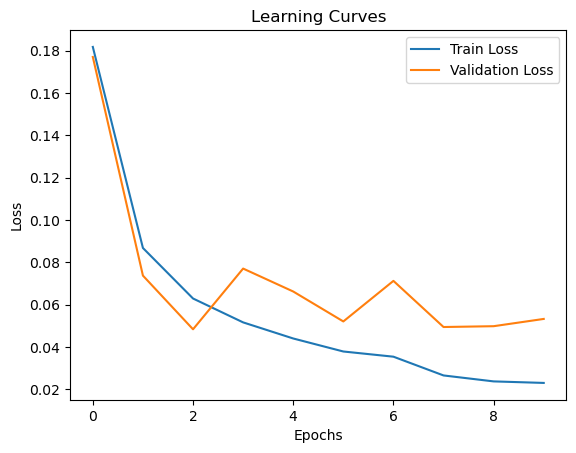

In [21]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()


### 
### Model Evaluation
#### This block Loads the best model and evaluates on the test set.

In [23]:
net.load_state_dict(torch.load('best_model.pth', weights_only=True))
net.eval()

correct = 0
total = 0
class_correct = [0, 0]
class_total = [0, 0]

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

print(f'Accuracy on test set: {100 * correct / total:.2f}%')
for i in range(2):
    print(f'Accuracy for {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')


Accuracy on test set: 98.28%
Accuracy for nonpulsar: 94.97%
Accuracy for pulsar: 98.35%


### 
### This block prints the ROC Curve and Confusion Matrix of Model

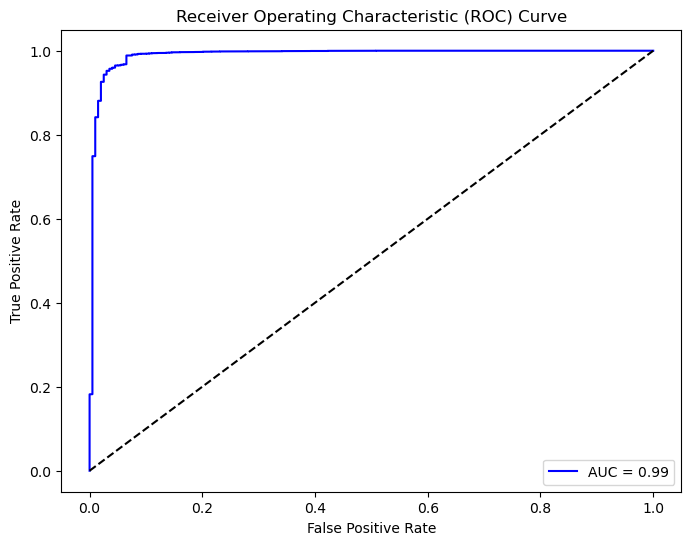

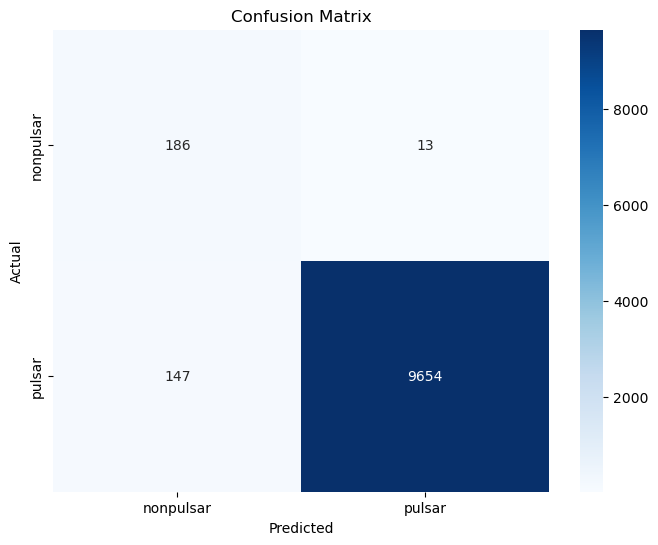

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.93      0.70       199
           1       1.00      0.99      0.99      9801

    accuracy                           0.98     10000
   macro avg       0.78      0.96      0.85     10000
weighted avg       0.99      0.98      0.99     10000



In [25]:
plot_roc_curve(net, testloader, device)
plot_confusion_matrix(net, testloader, device)
